In [1]:
#https://github.com/varnav/canon_cr3/blob/main/canon_cr3/__init__.py
from canon_cr3 import Image as Image3
from PIL import Image
import io
import pylab
from astropy.stats import SigmaClip
from photutils.background import Background2D, MedianBackground, SExtractorBackground
import numpy

#Im = numpy.array(Image.open(io.BytesIO(Image3('084A9935.CR3').jpeg_image)))
Im = numpy.array(Image.open(io.BytesIO(Image3('084A9935.CR3').jpeg_image)))

## Sky subtraction demo

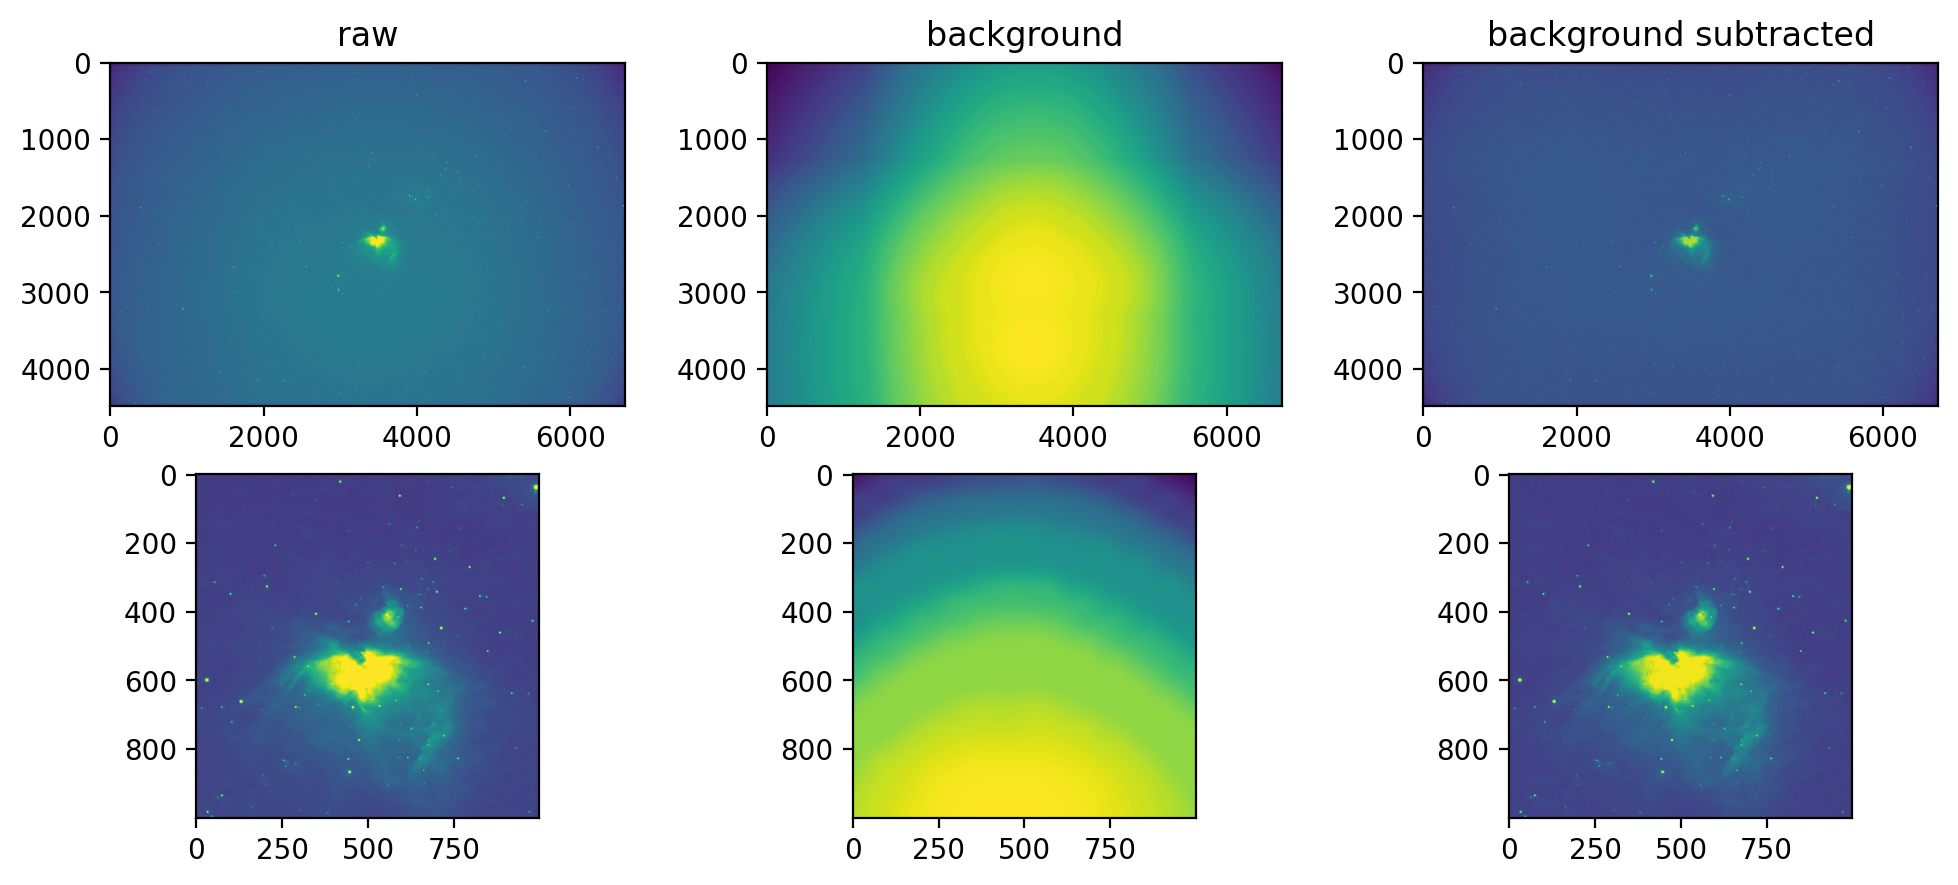

In [2]:
for i in range(Im.shape[2])[:1]:
    im = Im[:,:,i].astype(numpy.float64)
    sigma_clip = SigmaClip(sigma=3.)
    bkg_estimator = SExtractorBackground()
    bkg = Background2D(im, (50, 50), filter_size=(50, 50),
                       sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
    corr = im - bkg.background
    pylab.figure(figsize=(12,5),dpi=200)
    pylab.subplot(2,3,1)
    pylab.title("raw")
    pylab.imshow(im)
    pylab.subplot(2,3,2)
    pylab.title("background")
    pylab.imshow(bkg.background)
    pylab.subplot(2,3,3)
    pylab.title("background subtracted")    
    pylab.imshow(corr)
    pylab.subplot(2,3,4)
    pylab.imshow(im[1750:2750,3000:4000])
    pylab.subplot(2,3,5)
    pylab.imshow(bkg.background[1750:2750,3000:4000])
    pylab.subplot(2,3,6)
    pylab.imshow(corr[1750:2750,3000:4000])
    #    pylab.hist(im.flatten(),bins=256,range=(0,255))
#    pylab.hist(corr.flatten(),bins=256,range=(0,255))
    pylab.show()

## source detection

In [3]:
# https://photutils.readthedocs.io/en/stable/getting_started.html
from photutils.detection import DAOStarFinder
from astropy.stats import mad_std

# evalute sigma to determin threshold
bkg_sigma = mad_std(corr) 
# perform source detection
daofind = DAOStarFinder(fwhm=10., threshold=10.*bkg_sigma)
sources = daofind(corr)  

## Visualize 

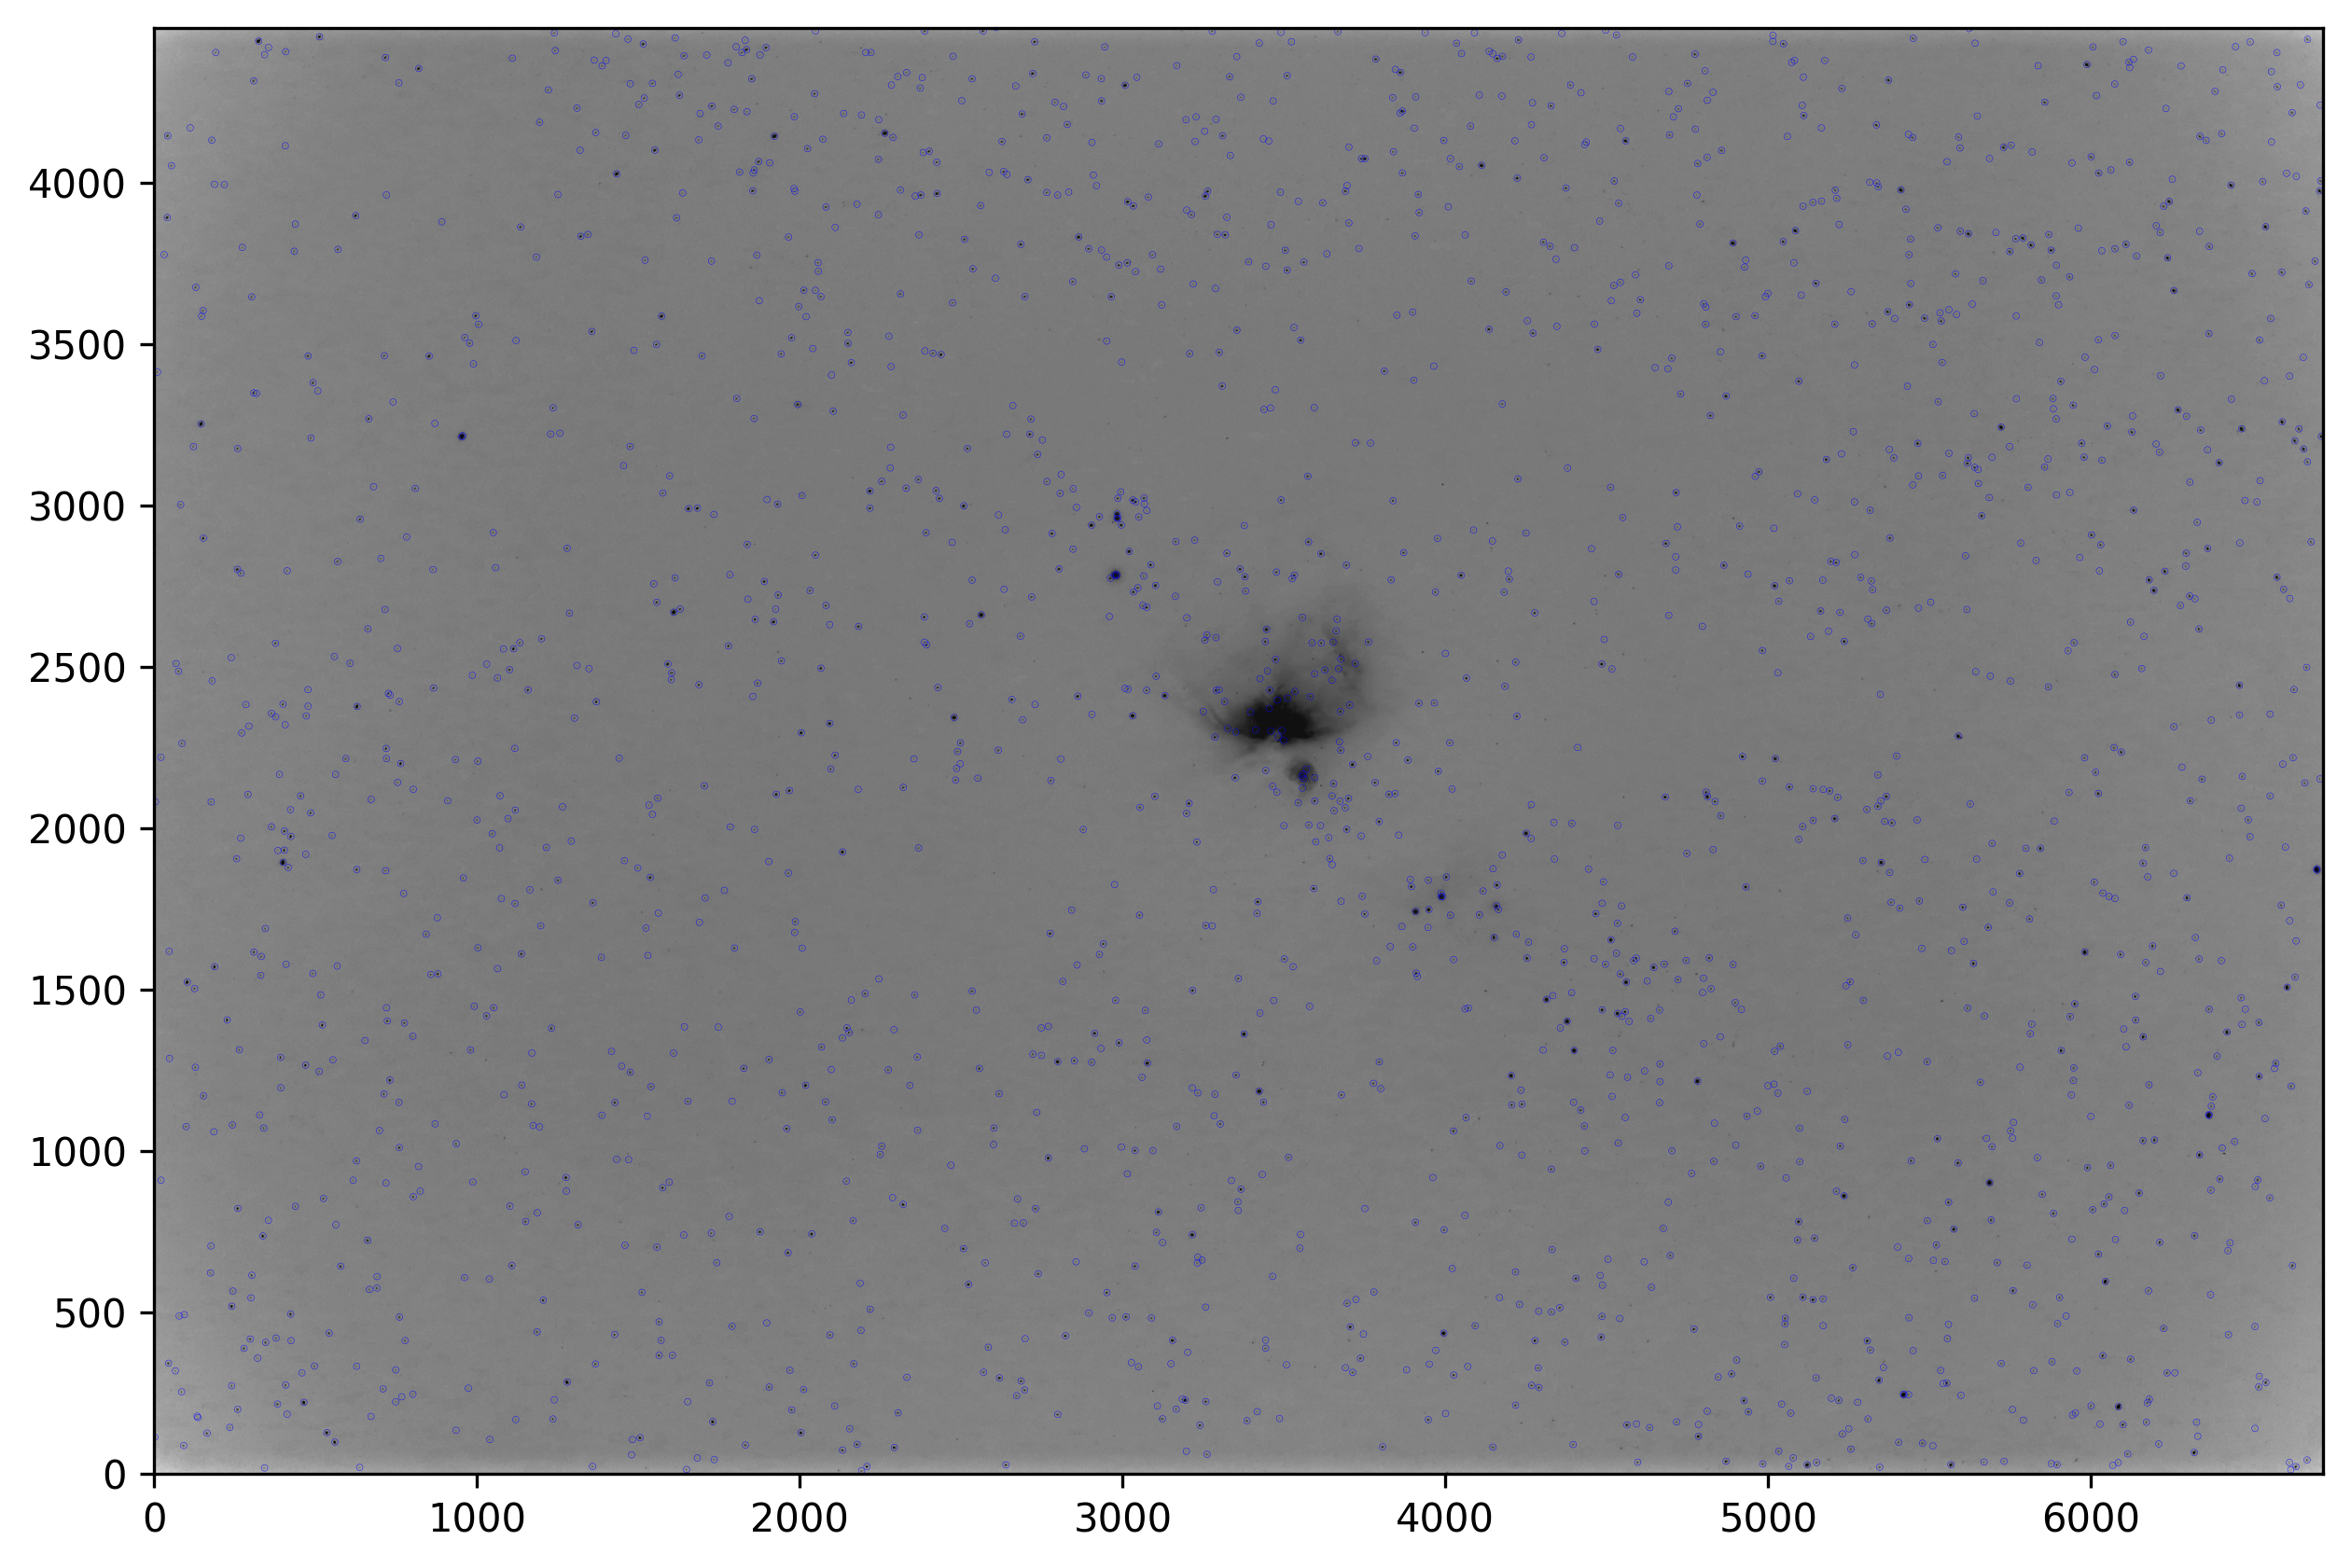

In [4]:
from photutils.aperture import aperture_photometry, CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
positions = numpy.transpose((sources['xcentroid'], sources['ycentroid']))  
apertures = CircularAperture(positions, r=10.)
phot_table = aperture_photometry(corr, apertures)  
pylab.figure(figsize=(10,10),dpi=300)
norm = ImageNormalize(stretch=SqrtStretch())
pylab.imshow(corr, cmap='gray_r', origin='lower',norm=norm)
apertures.plot(color='blue', lw=0.1, alpha=1)
pylab.show()

In [5]:
def MakeSourceCatalog(im):
    sigma_clip = SigmaClip(sigma=3.)
    bkg_estimator = SExtractorBackground()
    bkg = Background2D(im, (50, 50), filter_size=(50, 50),
          sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
    corr = im - bkg.background

        # evalute sigma to determin threshold
    bkg_sigma = mad_std(corr) 
    # perform source detection
    daofind = DAOStarFinder(fwhm=10., threshold=10.*bkg_sigma)
    sources = daofind(corr)

    positions = numpy.transpose((sources['xcentroid'], sources['ycentroid']))  
    apertures = CircularAperture(positions, r=10.)
    phot_table = aperture_photometry(corr, apertures)  
    return phot_table, corr, bkg.background

In [ ]:
import glob

table_array = []
for path in glob.glob("*.CR3"):
    Im = numpy.array(Image.open(io.BytesIO(Image3(path).jpeg_image)))
    im = Im[:,:,0].astype(numpy.float64)
    table, img, bkg = MakeSourceCatalog(im)
    table_array.append(table)


## Measure relative offset between exposures with respect to the first one

In [ ]:
from scipy.spatial import KDTree

fig = pylab.figure(figsize=(10,20),dpi=100)
kdtree = KDTree(numpy.array([table_array[0]["xcenter"],table_array[0]["ycenter"]]).T)
ax1 = pylab.subplot("211")
ax2 = pylab.subplot("212")

for atable in table_array[1:]:
    dd, ii = kdtree.query(numpy.array([atable["xcenter"],atable["ycenter"]]).T)
    delta = (kdtree.data[ii].T - [atable["xcenter"],atable["ycenter"]])
    survived = numpy.where(numpy.abs(dd-numpy.median(dd))<3*mad_std(dd))
    dx, dy = delta.T[survived].T
    ax1.plot(dx, dy,".",alpha=1)
    scale=100
    ax2.quiver(*(kdtree.data[ii][survived].T),
              scale*(dx-dx.mean()), scale*(dy-dy.mean()),
              units="xy",
              angles="xy",
              scale=1,
#              color = colormap(color)
               )